In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import PartialDependenceDisplay

from scipy.stats import randint
import shap

# Set seaborn style globally
sns.set(style="whitegrid")

# Label Encoder
le = LabelEncoder()

In [2]:
#Import Insurance Regression Data and describe the data
df = pd.read_csv(r"c:\Users\rmhs\OneDrive - Capco\Desktop\ADS\Rajsi ADS\Regression\data\insurance_regression.csv")
print(df.head())
df.info()
df.describe()

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [3]:
#Feature Engineering 

In [4]:
# Change all object *text* data to numerical - note variables are categorical
print(df["sex"].unique())
print(df["smoker"].unique())
print(df["region"].unique())

df = df.rename(columns={"sex": "gender"})

df_change = df.copy()
df_change["smoker"] = df_change["smoker"].map({"yes": 1, "no": 0})
df_change["gender"] = df_change["gender"].map({"male": 0, "female": 1})

#convert region to nominal numerical with label encoding - not one-hot encoding (to ensure everything stays in one column)
df_change["region_encoded"] = le.fit_transform(df_change["region"])

#drop the original text region - not going to be used for model
df_2 = df_change.drop("region", axis=1)
df_2 = df_2.rename(columns={"region_encoded": "region"})

['female' 'male']
['yes' 'no']
['southwest' 'southeast' 'northwest' 'northeast']


In [5]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   gender    1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   charges   1338 non-null   float64
 6   region    1338 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 73.3 KB


In [6]:
#EDA

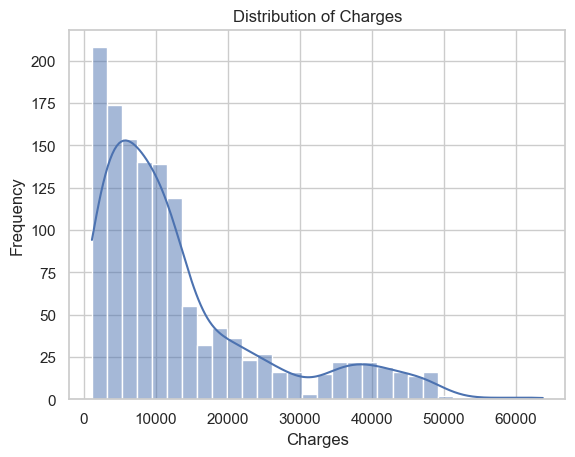

In [7]:
# Charges is Target Variable

#Target variable distribution
sns.histplot(df["charges"], kde=True)
plt.title("Distribution of Charges")
plt.xlabel("Charges")
plt.ylabel("Frequency")
plt.show()

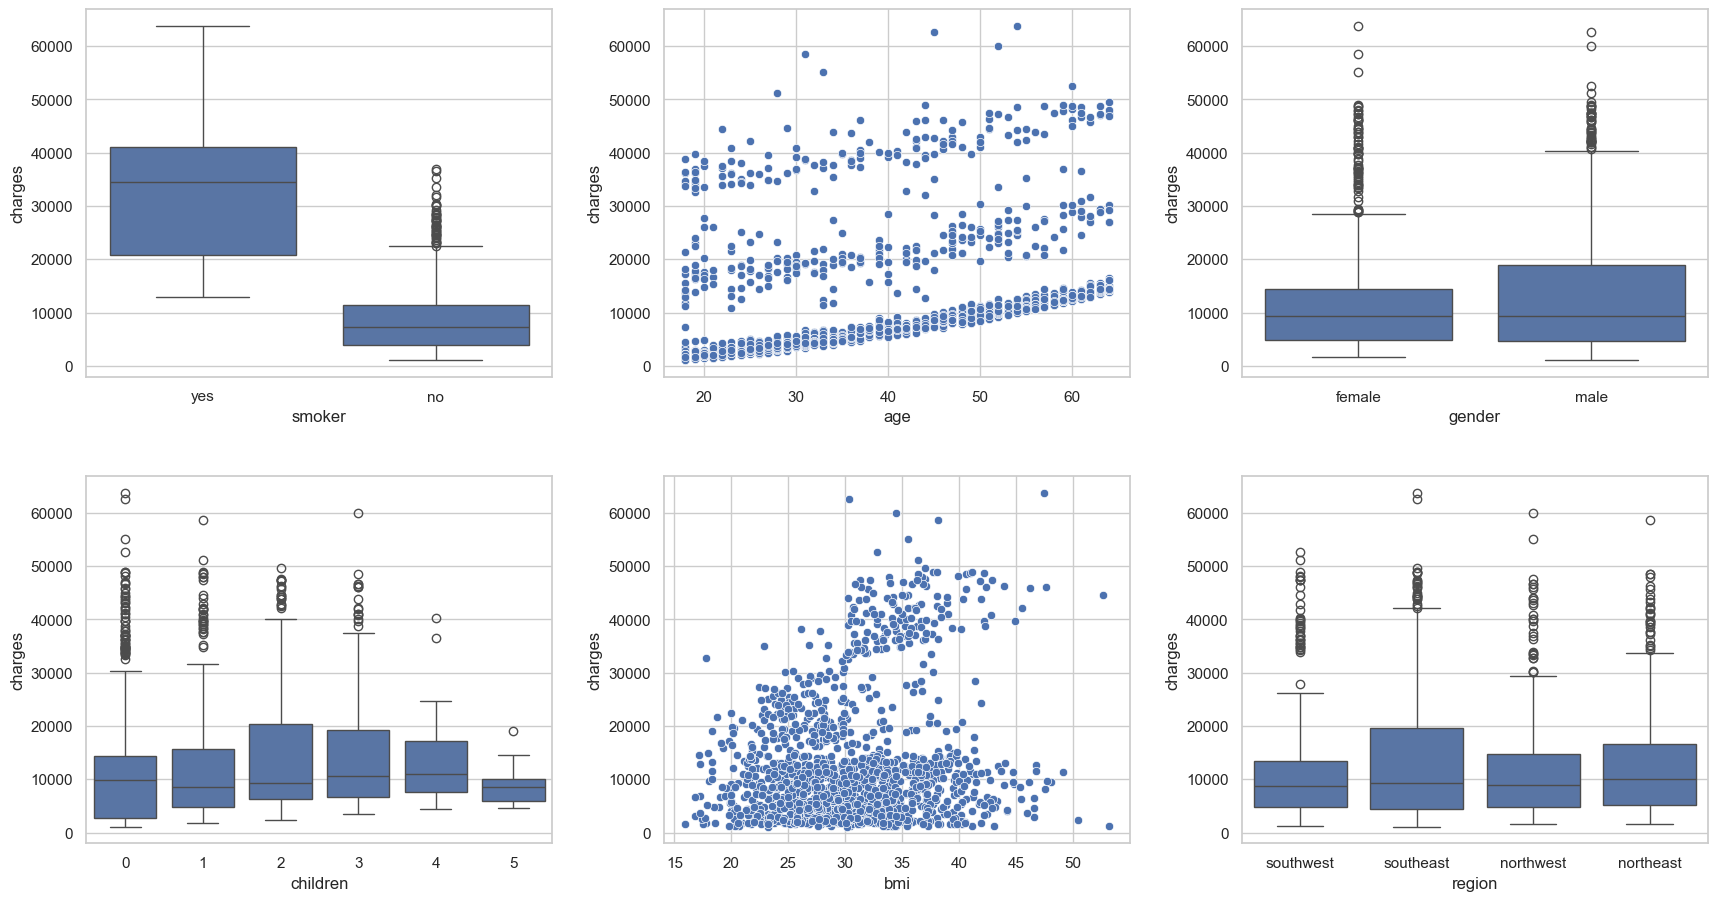

In [8]:
# Running all INDIVIDUAL variables against charges to see which has most impact against target variable
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.tight_layout(pad=4.0)
sns.boxplot(x="smoker", y="charges", data=df, ax=axes[0, 0])
sns.scatterplot(x="age", y="charges", data=df, ax=axes[0, 1])
sns.boxplot(x="gender", y="charges", data=df, ax=axes[0, 2])
sns.boxplot(x="children", y="charges", data=df, ax=axes[1, 0])
sns.scatterplot(x="bmi", y="charges", data=df, ax=axes[1, 1])
sns.boxplot(x="region", y="charges", data=df, ax=axes[1, 2])
plt.show()

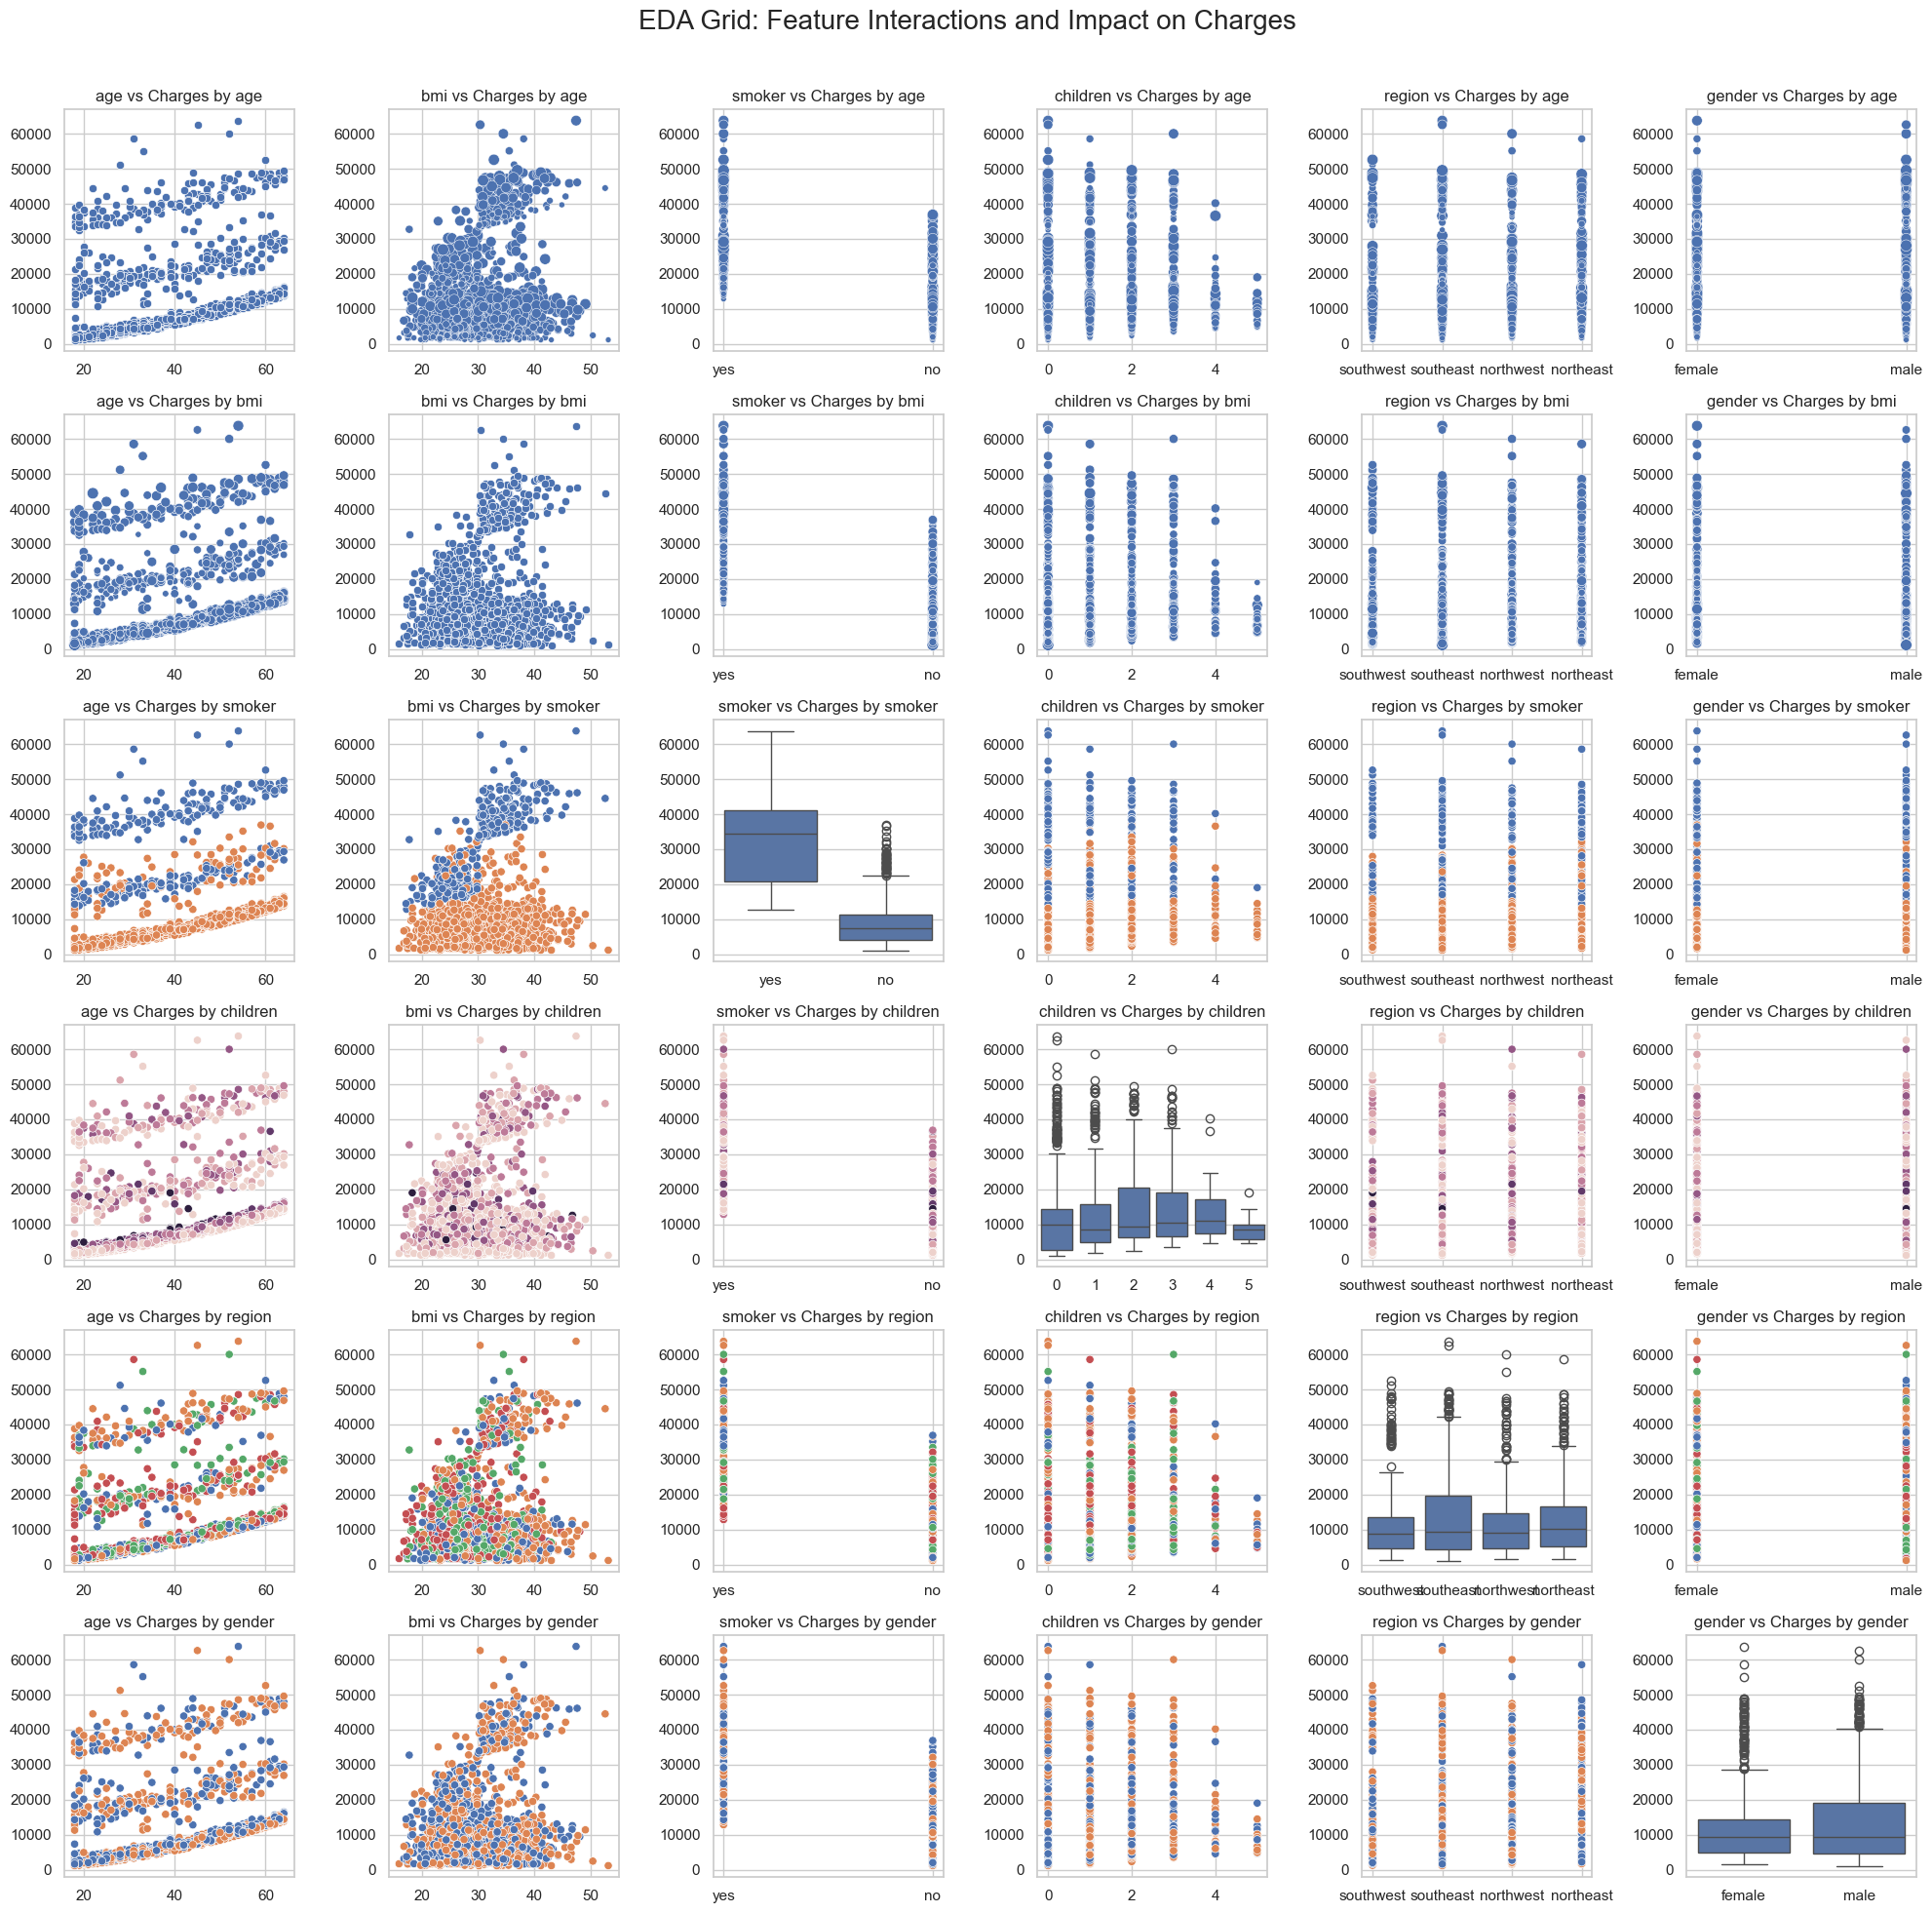

In [9]:
# 2 feature interaction grid
features = ["age", "bmi", "smoker", "children", "region", "gender"]
n = len(features)
fig, axes = plt.subplots(n, n, figsize=(20, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        x = features[j]
        hue = features[i]
        if i == j:
            if df[x].dtype == "object" or df[x].nunique() < 10:
                sns.boxplot(x=x, y="charges", data=df, ax=ax)
            else:
                sns.scatterplot(x=x, y="charges", data=df, ax=ax)
        else:
            if df[hue].dtype == "object" or df[hue].nunique() < 10:
                sns.scatterplot(x=x, y="charges", hue=hue, data=df, ax=ax, legend=False)
            else:
                sns.scatterplot(x=x, y="charges", size=hue, data=df, ax=ax, legend=False)
        ax.set_title(f"{x} vs Charges by {hue}")
        ax.set_xlabel("")
        ax.set_ylabel("")

plt.suptitle("EDA Grid: Feature Interactions and Impact on Charges", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


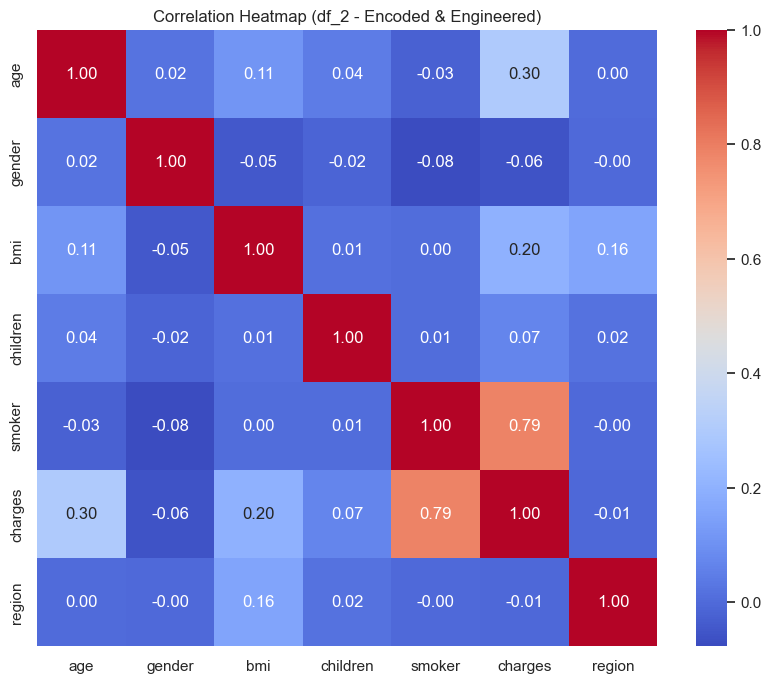

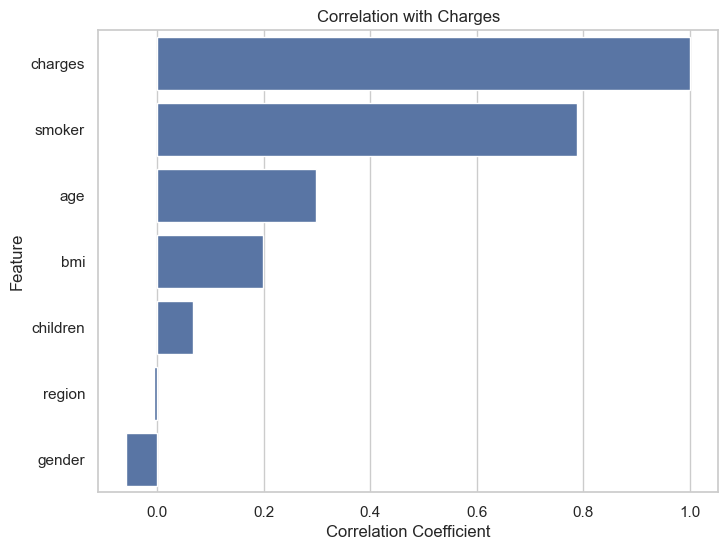

charges     1.000000
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
region     -0.006208
gender     -0.057292
Name: charges, dtype: float64

In [11]:
#basic heatmap with target correlation
corr = df_2.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (df_2 - Encoded & Engineered)")
plt.show()

# Plot only correlations with charges
corr_target = df_2.corr(numeric_only=True)["charges"].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=corr_target.values, y=corr_target.index)
plt.title("Correlation with Charges")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

corr = df_2.corr(numeric_only=True)
corr["charges"].sort_values(ascending=False)

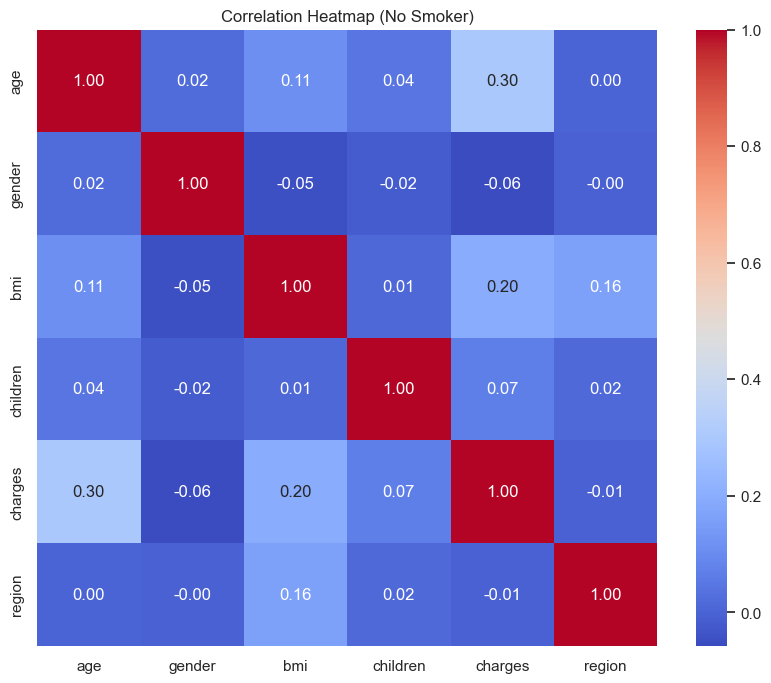

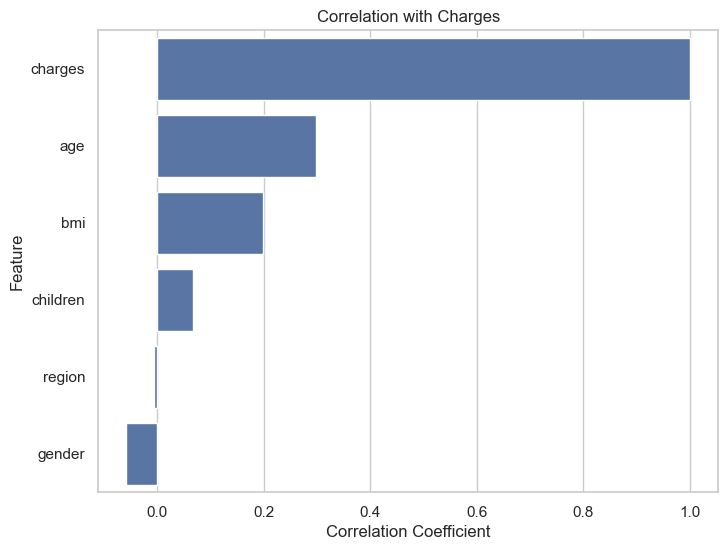

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
region     -0.006208
gender     -0.057292
Name: charges, dtype: float64

In [13]:
#EDA shows that Smoker is a huge impact on charges - drop smoker from the dataset and see if anything else has a strong interaction
df_nosmoker = df_2.drop("smoker", axis=1)
corr_nosmoker = df_nosmoker.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_nosmoker, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (No Smoker)")
plt.show()

# Plot only correlations with charges
corr_targetns = df_nosmoker.corr(numeric_only=True)["charges"].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=corr_targetns.values, y=corr_targetns.index)
plt.title("Correlation with Charges")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

corr_ns = df_nosmoker.corr(numeric_only=True)
corr_ns["charges"].sort_values(ascending=False)

In [14]:
#Modelling

In [15]:
#Model Set Up
df_model = df_2.copy()
print(df_model.shape)
print(df_model.columns)

(1338, 7)
Index(['age', 'gender', 'bmi', 'children', 'smoker', 'charges', 'region'], dtype='object')


In [16]:
# A: Full feature set (including 'smoker')
X_full = df_model.drop("charges", axis=1)

# B: Reduced feature set (excluding 'smoker' and optionally 'bmi_smoker' if it exists)
X_nosmoker = df_model.drop(["charges", "smoker"], axis=1)

# Target
y = df_model["charges"]

In [17]:
# Full version
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=13)

# Reduced version
X_train_nosmoker, X_test_nosmoker, y_train_nosmoker,y_test_nosmoker = train_test_split(X_nosmoker, y, test_size=0.3, random_state=13)

In [18]:
#Baseline Model Training

# Model A: With smoker
rf_full = RandomForestRegressor(random_state=13)
rf_full.fit(X_train_full, y_train)
pred_full = rf_full.predict(X_test_full)

# Model B: Without smoker
rf_nosmoker = RandomForestRegressor(random_state=13)
rf_nosmoker.fit(X_train_nosmoker, y_train_nosmoker)
pred_nosmoker = rf_nosmoker.predict(X_test_nosmoker)

# Model Evaluation
print("R² with smoker:", r2_score(y_test, pred_full))
print("MAE with smoker:", mean_absolute_error(y_test, pred_full))
print("R² without smoker:", r2_score(y_test_nosmoker, pred_nosmoker))
print("MAE without smoker:", mean_absolute_error(y_test_nosmoker, pred_nosmoker))

R² with smoker: 0.8738100917345621
MAE with smoker: 2420.841167907633
R² without smoker: -0.02665487716956827
MAE without smoker: 9396.358403768223


          With Smoker  Without Smoker
smoker       0.605564             NaN
bmi          0.213577        0.425379
age          0.136898        0.324387
children     0.022599        0.110549
region       0.015777        0.090876
gender       0.005586        0.048809


<Figure size 1000x600 with 0 Axes>

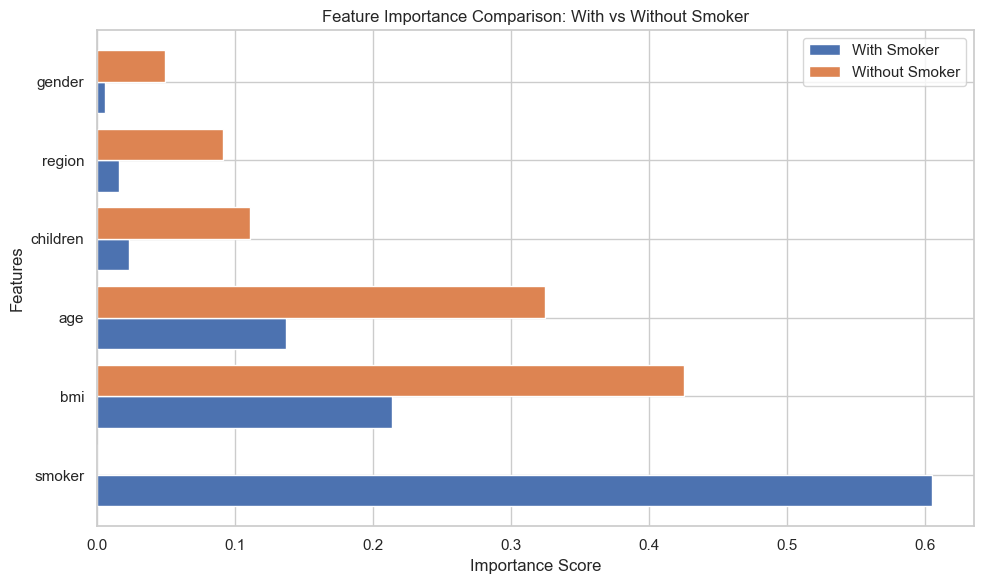

In [19]:
# Feature Importance Comparsion

importances_full = pd.Series(rf_full.feature_importances_, index=X_full.columns)
importances_nosmoker = pd.Series(rf_nosmoker.feature_importances_, index=X_nosmoker.columns)

# Side-by-side comparison
comparison_df = pd.DataFrame({
    "With Smoker": importances_full,
    "Without Smoker": importances_nosmoker
}).sort_values("With Smoker", ascending=False)

print(comparison_df)

plt.figure(figsize=(10, 6))
comparison_df.plot(kind="barh", figsize=(10, 6), width=0.8)

plt.title("Feature Importance Comparison: With vs Without Smoker")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

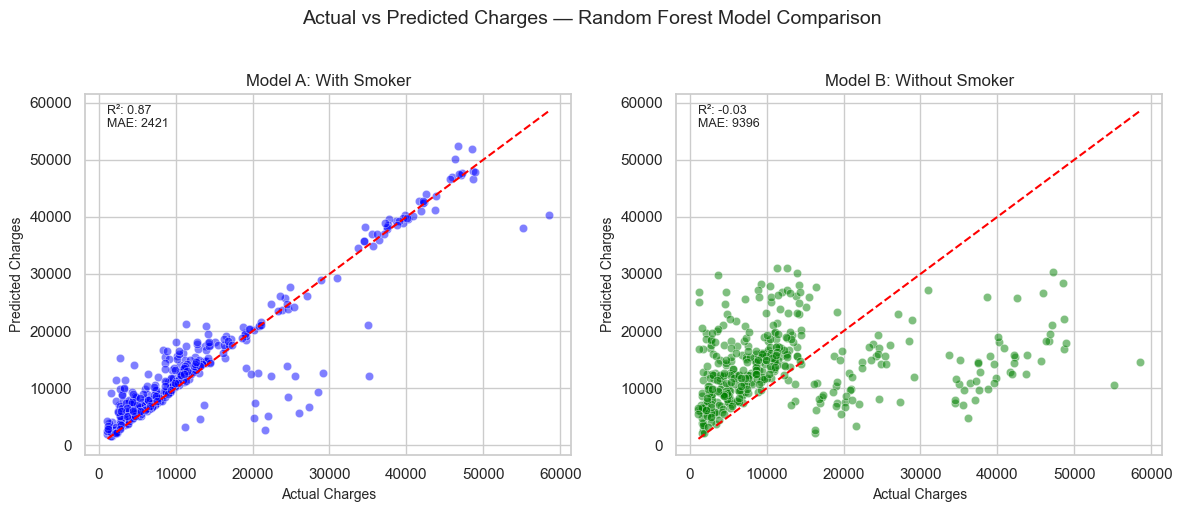

In [20]:
# Model Perfomance Visuals

r2_full = r2_score(y_test, pred_full)
r2_nosmoker = r2_score(y_test_nosmoker, pred_nosmoker)
mae_full = mean_absolute_error(y_test, pred_full)
mae_nosmoker = mean_absolute_error(y_test_nosmoker, pred_nosmoker)

plt.figure(figsize=(12, 5))

# Plot 1: With Smoker 
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=pred_full, alpha=0.5, color='blue', ax=ax1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Model A: With Smoker", fontsize=12)
plt.xlabel("Actual Charges", fontsize=10)
plt.ylabel("Predicted Charges", fontsize=10)
plt.text(y_test.min(), y_test.max()*0.95, f"R²: {r2_full:.2f}\nMAE: {mae_full:.0f}", fontsize=9)

#  Plot 2: Without Smoker 
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=pred_nosmoker, alpha=0.5, color='green', ax=ax2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Model B: Without Smoker", fontsize=12)
plt.xlabel("Actual Charges", fontsize=10)
plt.ylabel("Predicted Charges", fontsize=10)
plt.text(y_test.min(), y_test.max()*0.95, f"R²: {r2_nosmoker:.2f}\nMAE: {mae_nosmoker:.0f}", fontsize=9)

plt.suptitle("Actual vs Predicted Charges — Random Forest Model Comparison", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [21]:
#Model Fine Tuning

In [22]:
# Random Forest Tuning using RandomizedSearchCV

# Define parameter distribution
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(4, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create Random Forest Regressor
rf_base = RandomForestRegressor(random_state=13)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,              # number of combinations to try
    cv=5,                   # 5-fold cross-validation
    scoring='r2',           # or 'neg_mean_absolute_error'
    verbose=1,
    random_state=13,
    n_jobs=-1               # Use all cores
)

# Fit to training data
random_search.fit(X_train_full, y_train)

# Best model
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\rmhs\OneDrive - Capco\Desktop\ADS\Rajsi ADS\regression\venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rmhs\OneDrive - Capco\Desktop\ADS\Rajsi ADS\regression\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rmhs\OneDrive - Capco\Desktop\ADS\Rajsi ADS\regression\venv\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\rmhs\OneDrive - Capco\Desktop\ADS\Ra

Best Parameters: {'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 344}


In [23]:
# Final Model
final_rf = RandomForestRegressor(
    max_depth=9,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=3,
    n_estimators=344,
    random_state=13
)

# Train on full training data
final_rf.fit(X_train_full, y_train)

# Predict
final_rf_pred = final_rf.predict(X_test_full)

print("Final Tuned Model Performance")
print("R²:", r2_score(y_test, final_rf_pred))
print("MAE:", mean_absolute_error(y_test, final_rf_pred))

Final Tuned Model Performance
R²: 0.876153709668862
MAE: 2719.609205747044


c:\Users\rmhs\OneDrive - Capco\Desktop\ADS\Rajsi ADS\regression\venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


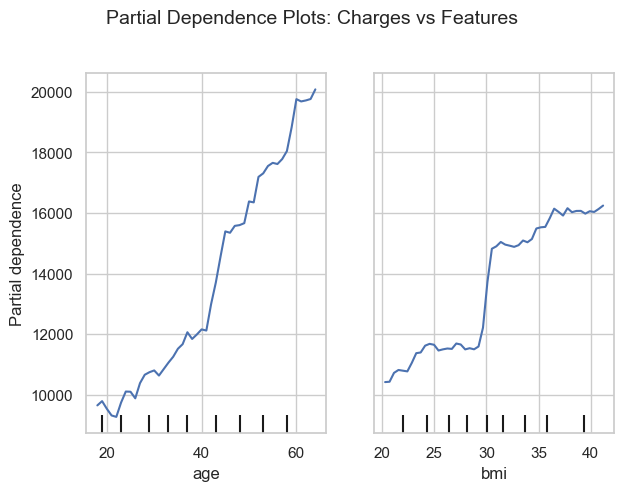

In [24]:
#Partial Dependence Plots
PartialDependenceDisplay.from_estimator(
    final_rf,
    X_test_full,
    features=['age', 'bmi'],
    kind="average",
    grid_resolution=50
)
plt.suptitle("Partial Dependence Plots: Charges vs Features", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

 96%|=================== | 385/402 [00:13<00:00]       

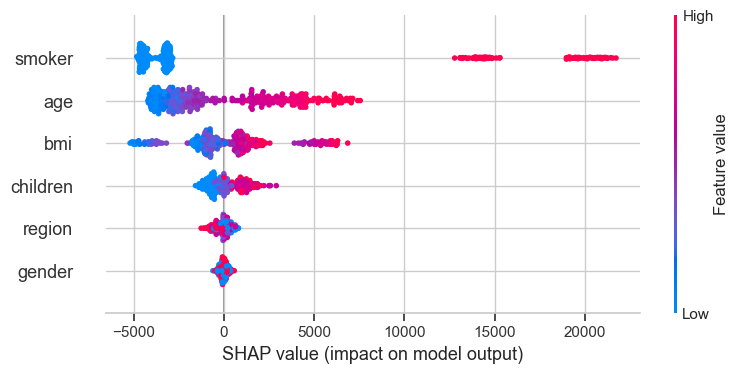

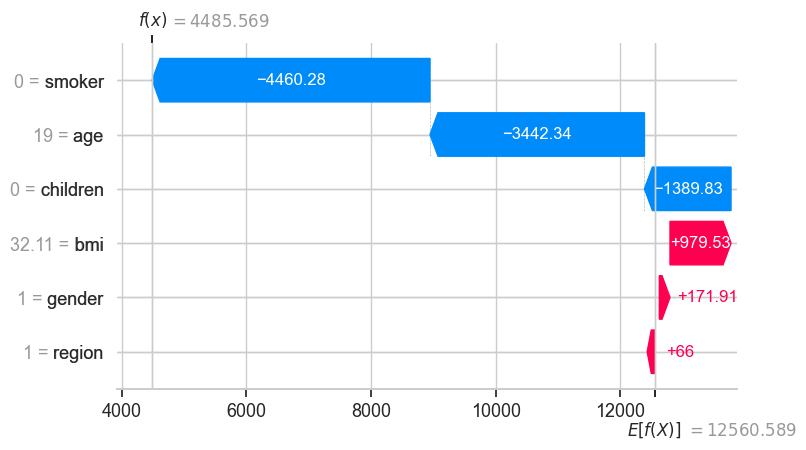

In [25]:
# SHAP EXPLAINABILITY

# Create the SHAP explainer for the final random forest model
explainer = shap.Explainer(final_rf, X_test_full)

# Compute SHAP values with additivity check turned off
shap_values = explainer(X_test_full, check_additivity=False)

# Global explanation: summary plot
shap.summary_plot(shap_values, X_test_full)

# Local explanation: individual prediction breakdown
# Example: show explanation for the first prediction in test set
shap.plots.waterfall(shap_values[0])